In [65]:
# importing necessary libraries
import re
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# importing some necessary preprocessing libraries
from wordcloud import WordCloud
from nltk import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.naive_bayes import GaussianNB
from nltk.tokenize import TweetTokenizer
from sklearn.preprocessing import StandardScaler

# for spliting, training and testing
from sklearn.model_selection import train_test_split

# importing the classifier models
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# import feature extractor
from sklearn.feature_extraction.text import CountVectorizer

# importing the classifiaction metrics
from sklearn.metrics import classification_report, accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [3]:
# reading in the data

train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
sample_df = pd.read_csv("data/sample_submission.csv")

In [4]:
# inspecting the first 5 rows

train_df.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [5]:
train_df.shape, test_df.shape

((15819, 3), (10546, 2))

In [6]:
train_df['sentiment'].unique()

array([ 1,  2,  0, -1], dtype=int64)

### 2: News - The tweet leads to factual news about climate change

### 1: Pro -The tweet supports the believe of man-induced climate change

### 0: Neutral - The tweet neither supports nor refutes the belief of climate change

### -1: Anti - The tweet does not believe in mad-induced climate change 

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


In [8]:
unique = train_df['message'].nunique()

print ('There are {} unique words in the Message corpus.'.format(unique))

There are 14229 unique words in the Message corpus.


### Percentage of people in each category

In [10]:
round(train_df['sentiment'].value_counts()*100/len(train_df), 2)

 1    53.92
 2    23.01
 0    14.87
-1     8.19
Name: sentiment, dtype: float64

In [11]:
train_df['sentiment'].value_counts()

 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

### Visualizing for proportion of respondents

array([<AxesSubplot:ylabel='message'>], dtype=object)

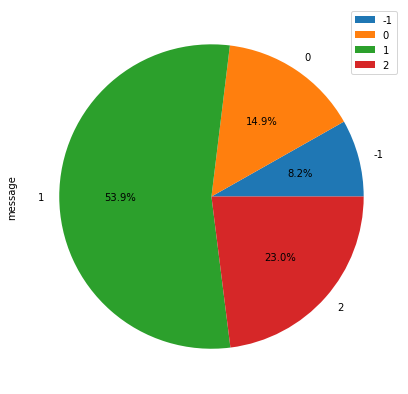

In [13]:
sums = train_df[['sentiment', 'message']].groupby('sentiment').count()
sums.plot(kind='pie', subplots=True, autopct='%1.1f%%', figsize=(7, 7))

Text(0.5, 1.0, 'Plot of Sentiments with magnitude')

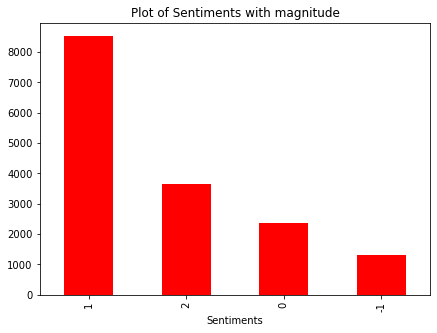

In [14]:
train_df['sentiment'].value_counts().plot(kind='bar', color='red', figsize=(7, 5))
plt.xlabel('Sentiments')
plt.title('Plot of Sentiments with magnitude')

### WordCloud of popoular terms

In [15]:
# we build a wordcloud for visualizing frequencies across the sentiment groups

def cloudy(data):
    
    WCloud = WordCloud(mask=None,max_font_size=150, 
                        width=800, height=400, max_words=40,
                        stopwords=stopwords.words('english')
                      ).generate(str(data))
    plt.figure(figsize=(12, 10))
    plt.imshow(WCloud, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    

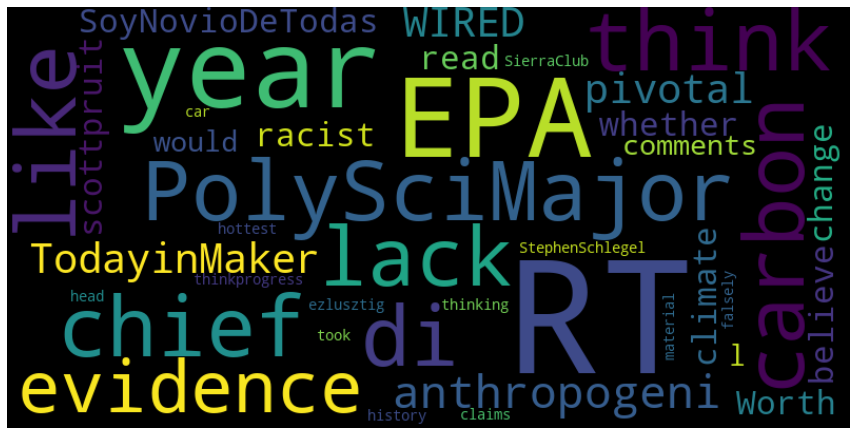

In [16]:
#Wordcloud of common words among those who Believes in Climate Change

cloudy([train_df.loc[train_df['sentiment'] ==1]['message']])

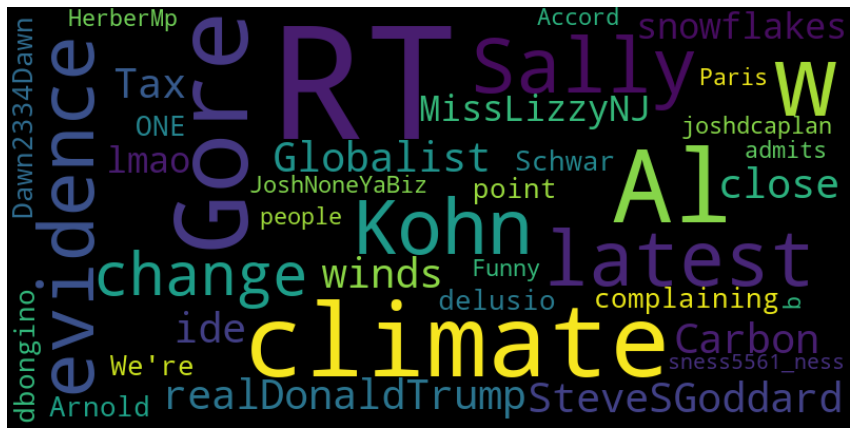

In [17]:
# Wordcloud of common words among those who do not believe in Climate Change

cloudy([train_df.loc[train_df['sentiment'] ==-1]['message']])

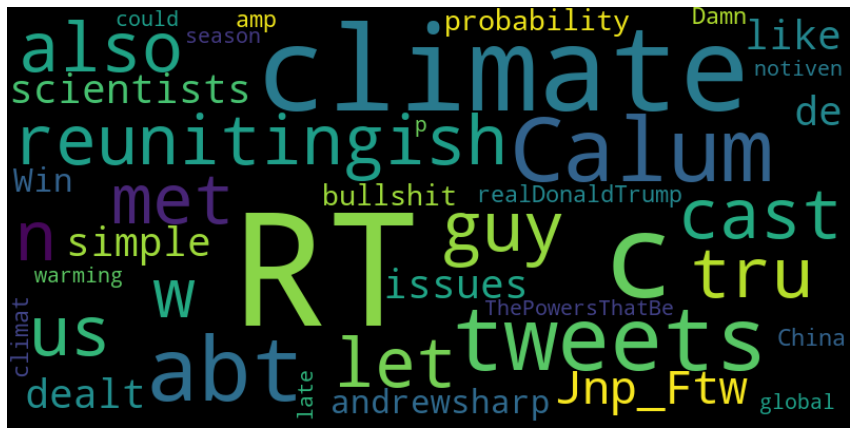

In [18]:
# Wordcloud of common words among those with Neutral perception about Climate Change

cloudy([train_df.loc[train_df['sentiment'] ==0]['message']])

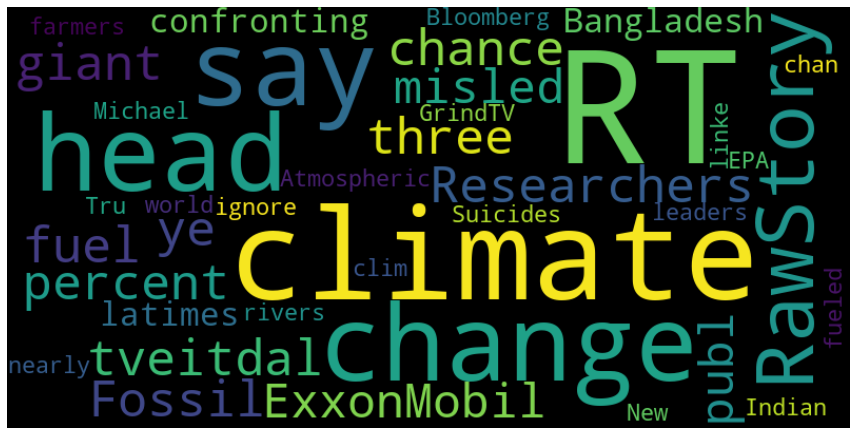

In [20]:
# Wordcloud of common words in the Factual News corpus

cloudy([train_df.loc[train_df['sentiment'] ==2]['message']])

### Splitting the tweets into their respective sentences

In [21]:
sentence = []
for i, row in train_df.iterrows():
    for j in row['message'].split(':'):
        sentence.append([row['sentiment'], j])
sentence = pd.DataFrame(sentence, columns=['sentiment', 'message'])

In [22]:
sentence

,sentiment,message
0,1,PolySciMajor EPA chief doesn't think carbon di...
1,1,//t.co/yeLvcEFXkC via @mashable
2,1,It's not like we lack evidence of anthropogeni...
3,2,RT @RawStory
4,2,Researchers say we have three years to act on...
...,...,...
38366,-1,RT @sara8smiles
38367,-1,Hey liberals the climate change crap is a hoa...
38368,0,RT @Chet_Cannon
38369,0,.@kurteichenwald's 'climate change equation' ...


### Visualizing the splitted tweets...

Text(0.5, 1.0, 'Plot of Sentiments with Magnitude')

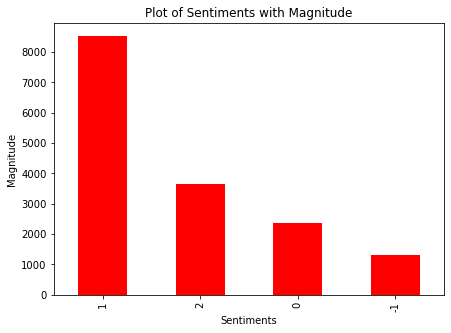

In [23]:
train_df['sentiment'].value_counts().plot(kind='bar', color='red', figsize=(7, 5))

plt.xlabel('Sentiments')
plt.ylabel('Magnitude')
plt.title('Plot of Sentiments with Magnitude')

In [24]:
figures = sentence['sentiment'].unique()
letters = ['Believe','News', 'Neutral', 'Disbelieve']

In [25]:
tables = pd.DataFrame(zip(figures, letters), columns=['Number', 'Sentiment'])
print(tables['Sentiment'])

0       Believe
1          News
2       Neutral
3    Disbelieve
Name: Sentiment, dtype: object


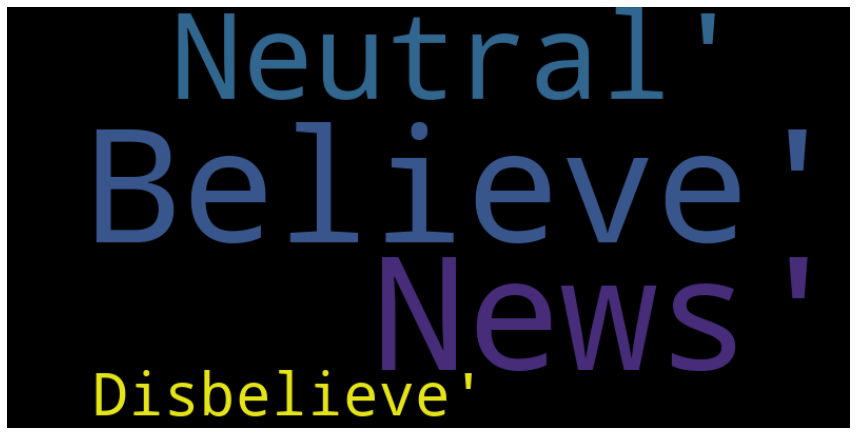

In [26]:
cloudy(tables['Sentiment'].values)

### Next, we replace site urls with prefered text

In [27]:
urls =  r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
rep_urls = r'replaced urls'

sentence['message'] = sentence['message'].replace(value=rep_urls, to_replace=urls, regex=True)

In [28]:
sentence['message'].head()

0    PolySciMajor EPA chief doesn't think carbon di...
1                      //t.co/yeLvcEFXkC via @mashable
2    It's not like we lack evidence of anthropogeni...
3                                         RT @RawStory
4     Researchers say we have three years to act on...
Name: message, dtype: object

### And convert the text to all lower case 

In [29]:
sentence['message'] = sentence['message'].str.lower()

In [30]:
sentence['message']

0        polyscimajor epa chief doesn't think carbon di...
1                          //t.co/yelvcefxkc via @mashable
2        it's not like we lack evidence of anthropogeni...
3                                             rt @rawstory
4         researchers say we have three years to act on...
                               ...                        
38366                                      rt @sara8smiles
38367     hey liberals the climate change crap is a hoa...
38368                                      rt @chet_cannon
38369     .@kurteichenwald's 'climate change equation' ...
38370                                    //t.co/lp7uufcxdq
Name: message, Length: 38371, dtype: object

### Next, punctuations are removed to further clean the dataset

In [31]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [32]:
def remove_puncs (message):
    return ''.join(i for i in message if i not in string.punctuation)

In [33]:
sentence['message'] = sentence['message'].apply(remove_puncs)

In [34]:
sentence['message'].iloc[22313]

' firms must come clean on exposure to climate change risks https'

### Next, we `Tokenize` the cleaned `sentence` into tokens

In [35]:
# instantiating the earlier imported tokenizer

tokeniser = TweetTokenizer()
sentence['tokens'] = sentence['message'].apply(tokeniser.tokenize)

In [36]:
sentence['tokens'].iloc[3425]

['shes',
 'thinking',
 'about',
 'how',
 'shes',
 'going',
 'to',
 'die',
 'because',
 'your',
 'husband',
 'doesnt',
 'believe',
 'in',
 'climate',
 'change',
 'https']

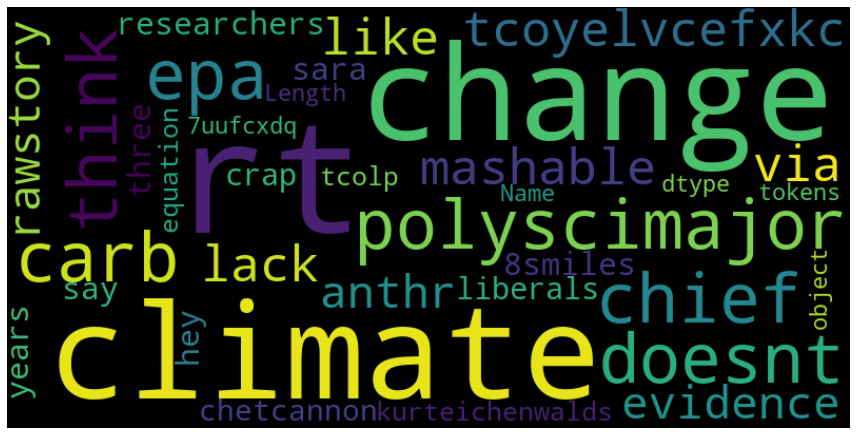

In [48]:
cloudy (sentence['tokens'])

### And `Stemmatize` back to the root words

In [49]:
stemmer = SnowballStemmer('english')

In [50]:
def mbti_stemmer(words, stemmer):
    return [stemmer.stem(word) for word in words]

In [51]:
sentence['stem'] = sentence['tokens'].apply(mbti_stemmer, args=(stemmer, ))

In [52]:
for i, t in enumerate(sentence.iloc[12402]['tokens']):    
    print ('{:20s} ==> {:10s}'.format(t, sentence.iloc[12402]['stem'][i]))

energy               ==> energi    
department           ==> depart    
tells                ==> tell      
staff                ==> staff     
to                   ==> to        
stop                 ==> stop      
using                ==> use       
phrase               ==> phrase    
climate              ==> climat    
change               ==> chang     
ecowatch             ==> ecowatch  
https                ==> https     


In [53]:
stopwords_list = stopwords.words('english')

In [54]:
def remove_stop_words(words):
    return ([text for text in words if text not in stopwords.words('english') ])

In [55]:
%%time 

sentence['stem'] = sentence['tokens'].apply(remove_stop_words) #Timey

CPU times: total: 1min 59s
Wall time: 2min


### Now, we attempt extracting features from the text using the `CountVectorizer` class

In [56]:
vect = CountVectorizer(stop_words='english', ngram_range=(1, 3), analyzer='word', max_df= 5, min_df=2, max_features=500)
X = vect.fit_transform(sentence['message']).toarray()

In [57]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

### Afterwards, we standardize the features

In [58]:
X_scaled = StandardScaler()

In [59]:
X = X_scaled.fit_transform(X)
X

array([[-0.01141594, -0.01141594, -0.01141594, ..., -0.01141594,
        -0.01141594, -0.01141594],
       [-0.01141594, -0.01141594, -0.01141594, ..., -0.01141594,
        -0.01141594, -0.01141594],
       [-0.01141594, -0.01141594, -0.01141594, ..., -0.01141594,
        -0.01141594, -0.01141594],
       ...,
       [-0.01141594, -0.01141594, -0.01141594, ..., -0.01141594,
        -0.01141594, -0.01141594],
       [-0.01141594, -0.01141594, -0.01141594, ..., -0.01141594,
        -0.01141594, -0.01141594],
       [-0.01141594, -0.01141594, -0.01141594, ..., -0.01141594,
        -0.01141594, -0.01141594]])

### Defining the `Target` variable

In [60]:
y = sentence['sentiment'] 

### And training the model

In [61]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.10, random_state=11)

In [62]:
# instantiating the model
logc = LogisticRegression(random_state=11, max_iter=10, C=1, n_jobs=2, verbose=False)

# fitting the Logistic Regression Model
logc.fit(X_train, y_train)

LogisticRegression(C=1, max_iter=10, n_jobs=2, random_state=50, verbose=False)

In [63]:
%%time

# instantiating the model
svc = SVC(C=1, gamma='scale', kernel='rbf')

# fitting the model
svc.fit(X_train, y_train)

CPU times: total: 8min 40s
Wall time: 9min 8s


SVC(C=1)

In [66]:
%%time

# instantiating the model
nbaye = GaussianNB()

# fitting the model
nbaye.fit(X_train, y_train)

CPU times: total: 484 ms
Wall time: 497 ms


GaussianNB()

In [67]:
%%time

# instantiating the model
randf = RandomForestClassifier()

# fitting the model
randf.fit(X_train, y_train)

CPU times: total: 3min 33s
Wall time: 3min 44s


RandomForestClassifier()

In [68]:
# instantiating the model
booc = AdaBoostClassifier(n_estimators=1, random_state=11)

# fitting the model
booc.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=1, random_state=50)

In [69]:
# instantiating the model
knc = KNeighborsClassifier()

# fitting the model
knc.fit(X_train, y_train)

KNeighborsClassifier()

### Now we build a function to compute the reports

In [86]:
def scoring (model):
    pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, model.predict(X_val))
    conf_m = classification_report(y_val, model.predict(X_val))
    return print(round(accuracy, 4),'\n\n', conf_m)

In [87]:
scoring (logc)

0.5526 

               precision    recall  f1-score   support

          -1       0.67      0.06      0.10       251
           0       0.30      0.02      0.04       444
           1       0.55      0.99      0.71      2106
           2       0.61      0.02      0.04      1037

    accuracy                           0.55      3838
   macro avg       0.53      0.27      0.22      3838
weighted avg       0.55      0.55      0.41      3838



In [89]:
scoring (svc)

0.5534 

               precision    recall  f1-score   support

          -1       0.75      0.05      0.09       251
           0       0.38      0.01      0.03       444
           1       0.55      0.99      0.71      2106
           2       0.60      0.02      0.04      1037

    accuracy                           0.55      3838
   macro avg       0.57      0.27      0.22      3838
weighted avg       0.56      0.55      0.41      3838



In [90]:
scoring (randf)

0.5547 

               precision    recall  f1-score   support

          -1       0.70      0.06      0.10       251
           0       0.42      0.02      0.04       444
           1       0.55      0.99      0.71      2106
           2       0.57      0.03      0.05      1037

    accuracy                           0.55      3838
   macro avg       0.56      0.27      0.23      3838
weighted avg       0.55      0.55      0.41      3838



In [91]:
scoring (nbaye)

0.0829 

               precision    recall  f1-score   support

          -1       0.07      0.98      0.13       251
           0       0.24      0.03      0.05       444
           1       0.77      0.02      0.03      2106
           2       0.49      0.02      0.04      1037

    accuracy                           0.08      3838
   macro avg       0.39      0.26      0.06      3838
weighted avg       0.59      0.08      0.04      3838



In [92]:
scoring(booc)

0.5487 

               precision    recall  f1-score   support

          -1       0.00      0.00      0.00       251
           0       0.00      0.00      0.00       444
           1       0.55      1.00      0.71      2106
           2       0.00      0.00      0.00      1037

    accuracy                           0.55      3838
   macro avg       0.14      0.25      0.18      3838
weighted avg       0.30      0.55      0.39      3838



In [93]:
scoring (knc)

0.5529 

               precision    recall  f1-score   support

          -1       0.67      0.05      0.09       251
           0       0.33      0.02      0.03       444
           1       0.55      0.99      0.71      2106
           2       0.55      0.02      0.04      1037

    accuracy                           0.55      3838
   macro avg       0.52      0.27      0.22      3838
weighted avg       0.53      0.55      0.41      3838



# Test Data

### Now we replicate all transformations to the `Train` data, on the `Test` data

In [94]:
test_df['message'] = [i.split('#') for i in test_df['message']]
sentences = pd.DataFrame(test_df['message'])


urls = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@ã¢â¬¢.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
new_url = r'replaced_url'
sentences['message'] = sentences['message'].replace(value=urls, to_replace= new_url, regex=True)


sentences['message'] = sentences['message'].apply(remove_puncs)


tokeniser = TweetTokenizer()
sentences['tokens'] = sentences['message'].apply(tokeniser.tokenize)


sentences['stem'] = sentences['tokens'].apply(mbti_stemmer, args=(stemmer, ))

sentences['stem'] = sentences['stem'].apply(remove_stop_words) #Timey


count_vect = CountVectorizer(stop_words='english', ngram_range=(1, 2), analyzer='word', max_df= 5, min_df=2, max_features=500)
y_tests = count_vect.fit_transform(sentences['message']).toarray()


y_test_scaled = StandardScaler()
y_test = y_test_scaled.fit_transform(y_tests)

In [95]:
y_test = logc.predict(y_tests)
y_test

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [96]:
submission = pd.DataFrame({'tweetid':sample_df['tweetid'], 'sentiment':y_test})
submission

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,1
...,...,...
10541,895714,1
10542,875167,1
10543,78329,1
10544,867455,1


In [97]:
submission = submission.to_csv('classi_submission.csv', index=False)
submission

### Finally, we save our model for reusability

In [98]:
import pickle

In [99]:
with open ('classi_model', 'wb') as f:
    pickle.dump(y_test, f)

In [100]:
with open ('classi_model', 'rb') as f:
    predictions = pickle.load(f)

ha😉❤

## Observation

1. From all observations, it could be observed that there are more people who Believe (54%) in the concept of climate change, compared to those who are Neutral (23%) and those who Don't beleive (15%) in climate change, as a result of their tweet.


2. A list of top 5 commonly recurring words among:

      i.    Believers of the climate change are    -> carbon, anthropogenic, EPA, evidence, think
    
      ii.   Disbelievers of climate change         -> climate, globalist, evidence, AI, carbon 
    
      iii.  Neutral opinions about climate change  -> climate, reuniting, tweets, scientist, guy
    
      iv.   Factual News from the tweet            -> climate, change, researchers, rawstory, confronting


3. Among the 5 classification and 1 ensemble method applied in modelling the solution, Logistic Regression, Support Vector Classifier, RandomForest Classifier and KNearestNeighbour all performed pretty much equally on the train data with a F1 value of 0.54. However, Boosting Ensembling technique and Naive Baye tend to have the least set of performance among all models.


4. Between all models, the Logistics Regression Classifier was adopted because it tend to have more improved Recall scores for actual predictions.


5. As a result of this, the company can be certain that the target segment on twitter are pretty much environmentally conscious and are aware of climate change. Hence, the need to manufacture climate-smart products.


6. Similarly, terms commonly used by people in each of the 4 segments, could be used in tailoring adverts, promotions and persuasive messages to such target audience.

#### Thanks for coming to the 'Classi Pari'.😎


#### Now you can catch a ride home.🚄


#### Arios!🤡